## Bayesian Model with Proactiv Data

In [1]:
import arviz as az
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt

In [2]:
from arviz.utils import Numba
Numba.disable_numba()

In [3]:
data = pd.read_csv('original_dataset_proactiv.csv')

In [8]:
X = data.iloc[:, :9]
y = data['Revenue']

In [9]:
def saturate(x, a):
    return 1 - tt.exp(-a*x)

def carryover(x, strength, length=21):
    w = tt.as_tensor_variable(
        [tt.power(strength, i) for i in range(length)]
    )
    
    x_lags = tt.stack(
        [tt.concatenate([
            tt.zeros(i),
            x[:x.shape[0]-i]
        ]) for i in range(length)]
    )
    
    return tt.dot(w, x_lags)

In [10]:
with pm.Model() as mmm:
    channel_contributions = []
    
    for channel in X.columns:
        coef = pm.Exponential(f'coef_{channel}', lam=0.0001)
        sat = pm.Exponential(f'sat_{channel}', lam=1)
        car = pm.Beta(f'car_{channel}', alpha=2, beta=2)
        
        channel_data = X[channel].values
        channel_contribution = pm.Deterministic(
            f'contribution_{channel}',
            coef * saturate(
                carryover(
                    channel_data,
                    car
                ),
                sat
            )
        )
        
        channel_contributions.append(channel_contribution)
        
    base = pm.Exponential('base', lam=0.0001)
    noise = pm.Exponential('noise', lam=0.0001)
    
    sales = pm.Normal(
        'sales',
        mu=sum(channel_contributions) + base,
        sigma=noise,
        observed=y
    )
    
    trace = pm.sample(return_inferencedata=True, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, base, car_YouTube_MediaCost, sat_YouTube_MediaCost, coef_YouTube_MediaCost, car_Snapchat_MediaCost, sat_Snapchat_MediaCost, coef_Snapchat_MediaCost, car_Radio_MediaCost, sat_Radio_MediaCost, coef_Radio_MediaCost, car_Pinterest_MediaCost, sat_Pinterest_MediaCost, coef_Pinterest_MediaCost, car_GoogleSearch_MediaCost, sat_GoogleSearch_MediaCost, coef_GoogleSearch_MediaCost, car_Facebook_MediaCost, sat_Facebook_MediaCost, coef_Facebook_MediaCost, car_DV360_MediaCost, sat_DV360_MediaCost, coef_DV360_MediaCost, car_BingSearch_MediaCost, sat_BingSearch_MediaCost, coef_BingSearch_MediaCost, car_Amazon_MediaCost, sat_Amazon_MediaCost, coef_Amazon_MediaCost]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 222 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 327 divergences after tuning. Increase `target_accept` or reparameterize.
There were 349 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6565124691303833, but should be close to 0.8. Try to increase the number of tuning steps.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'coef_Amazon_MediaCost'}>,
        <AxesSubplot:title={'center':'sat_Amazon_MediaCost'}>,
        <AxesSubplot:title={'center':'car_Amazon_MediaCost'}>,
        <AxesSubplot:title={'center':'coef_BingSearch_MediaCost'}>],
       [<AxesSubplot:title={'center':'sat_BingSearch_MediaCost'}>,
        <AxesSubplot:title={'center':'car_BingSearch_MediaCost'}>,
        <AxesSubplot:title={'center':'coef_DV360_MediaCost'}>,
        <AxesSubplot:title={'center':'sat_DV360_MediaCost'}>],
       [<AxesSubplot:title={'center':'car_DV360_MediaCost'}>,
        <AxesSubplot:title={'center':'coef_Facebook_MediaCost'}>,
        <AxesSubplot:title={'center':'sat_Facebook_MediaCost'}>,
        <AxesSubplot:title={'center':'car_Facebook_MediaCost'}>],
       [<AxesSubplot:title={'center':'coef_GoogleSearch_MediaCost'}>,
        <AxesSubplot:title={'center':'sat_GoogleSearch_MediaCost'}>,
        <AxesSubplot:title={'center':'car_GoogleSearch_MediaCost'}>,
        <AxesS

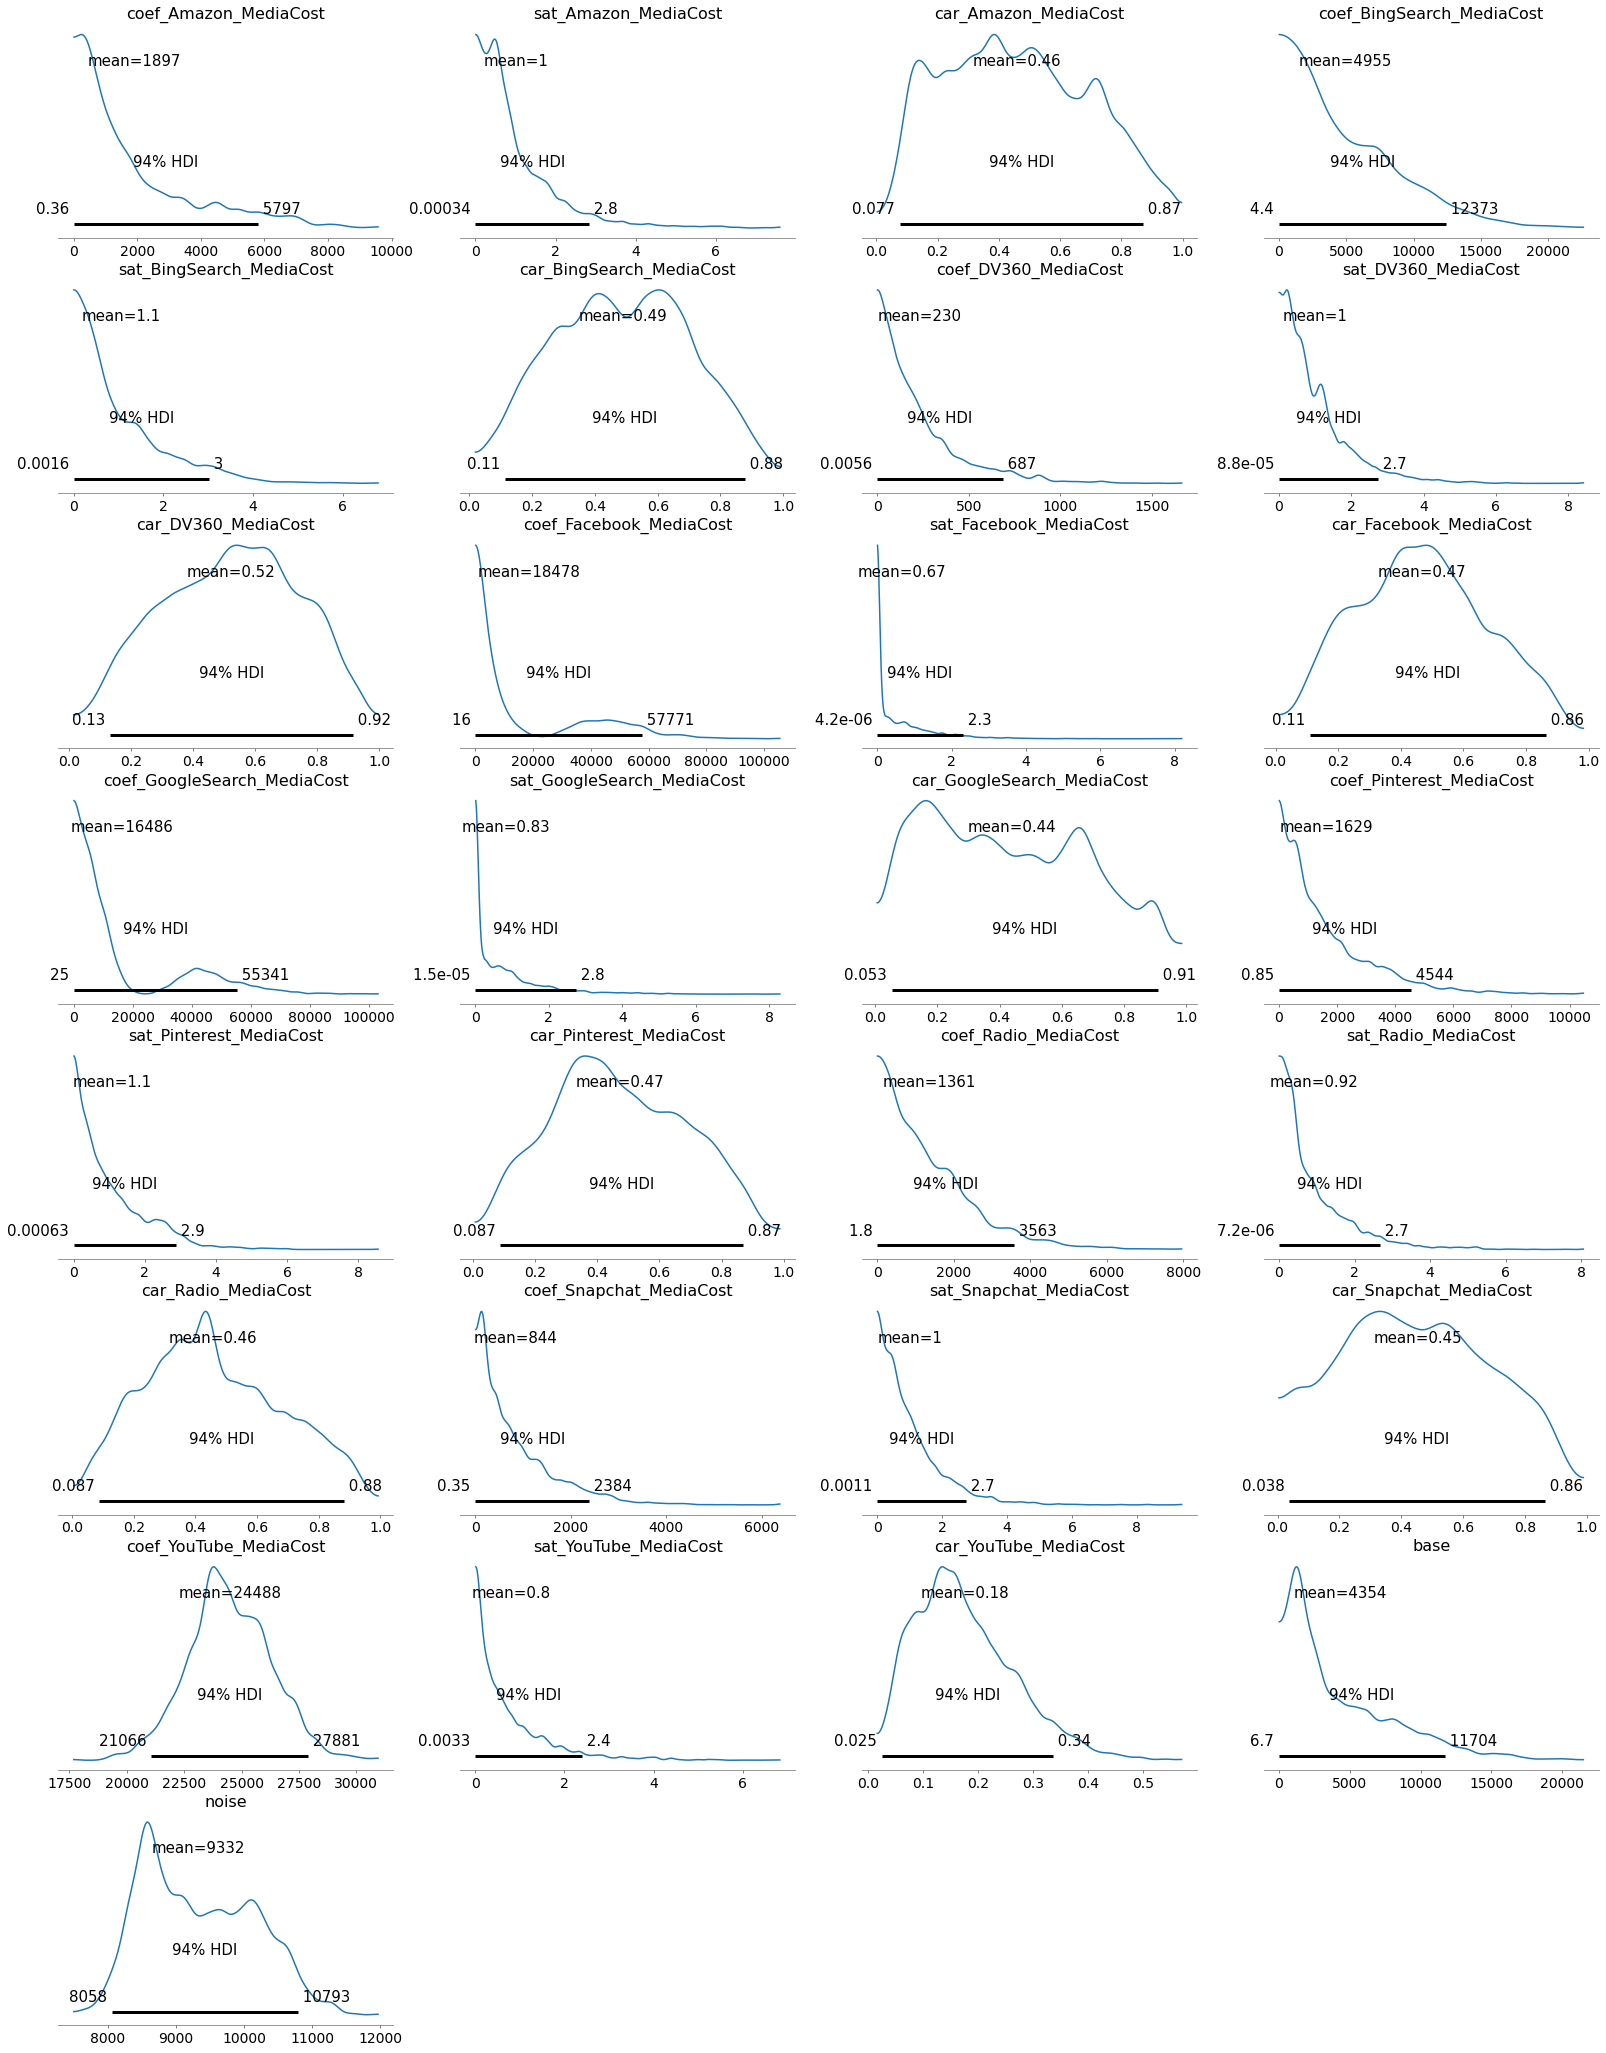

In [11]:
az.plot_posterior(
    trace,
    var_names=['~contribution'],
    filter_vars='like'
)

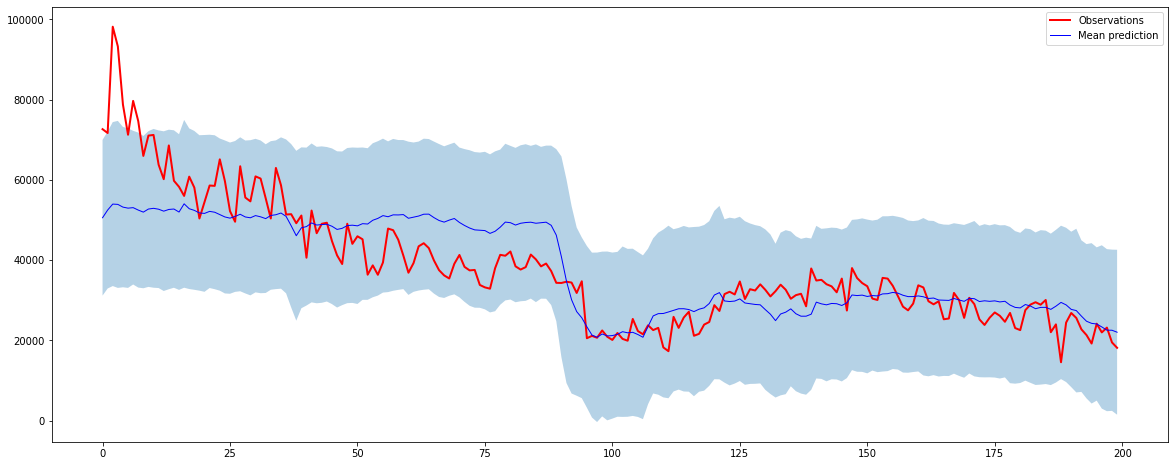

In [12]:
with mmm:
    posterior = pm.sample_posterior_predictive(trace)
means = posterior['sales'].mean(0)
stds = posterior['sales'].std(0)
plt.figure(figsize=(20, 8))
plt.plot(y.values, linewidth=2, c='r', label='Observations')
plt.plot(means, linewidth=1, c='b', label='Mean prediction')
plt.fill_between(np.arange(len(y)), means - 2*stds, means + 2*stds, alpha=0.33)
plt.legend()